# TP2 — Suivi de route avec **Mushroom Body** (OpenCV + NumPy)

## Objectifs
- Construire un pipeline visuel minimal (OpenCV/NumPy) pour **apprendre** et **reconnaître** une route sur une grille d'images.
- Implémenter un **Mushroom Body** (MB) simplifié pour mesurer la **familiarité** entre images.
- Reproduire une **IDF** (Image Difference/Familiarity Function) par rotation et estimer son cap.

## Plan du notebook
0. Imports & setup  
1. Chargement du dataset & visualisation  
2. Conception d'un **Mushroom Body** simple (`class`)  
3. Apprentissage de la **base de données route** avec le MB et visualization des différentes étapes
4. Reproduction de l'**IDF** pour chaque image de la route avec le MB et plot de la surface 3D
5. Estimer son cap avec une image aléatoire sur la route


## 0. Imports & setup

In [1]:
COLAB = True

if COLAB:
    # === Téléchargement & extraction des données dans ./data ===========================
    from pathlib import Path
    import urllib.request, zipfile, tarfile, io, os

    # Indiquez le lien direct du dataset ; .zip / .tar.gz recommandés
    DATA_URL = "https://filesender.renater.fr/download.php?token=ffab855e-64b5-4741-8519-51337987420d&files_ids=61990814"  # <-- REMPLACEZ-MOI (lien de données)
    DATA_DIR = Path("../data")
    DATA_DIR.mkdir(exist_ok=True)

    def download(url: str) -> bytes:
        print(f"Téléchargement depuis {url} …")
        with urllib.request.urlopen(url) as r:
            return r.read()

    blob = download(DATA_URL)

    # Détection simple des formats courants, sinon écriture binaire brute
    with zipfile.ZipFile(io.BytesIO(blob)) as zf:
        zf.extractall(DATA_DIR)

    # Aperçu du contenu
    print("Aperçu:", [p.name for p in DATA_DIR.glob('*')][:10])


Téléchargement depuis https://filesender.renater.fr/download.php?token=ffab855e-64b5-4741-8519-51337987420d&files_ids=61990814 …
Aperçu: ['dataset_C', 'dataset_A', '.gitkeep', 'dataset_B']


In [2]:
DB_DIR = '../data/dataset_C/grid'  # change to your folder
DB_DIR_ROUTE = '../data/dataset_C/route'

# Imports
import os, re, math, glob
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import display
from pathlib import Path
import cv2
import time 
from matplotlib import cm

%matplotlib inline

np.set_printoptions(precision=3, suppress=True)
plt.rcParams['figure.figsize'] = (7, 5)

## 1. Chargement du jeu de données & visualisation

Description de **dataset_C** — Jeu d’images **fisheye** pointées vers le haut, chacune en **320×320×3 px** avec un **champ de vision (FOV) de 220°**. Il comprend deux sous-ensembles :

* une **grille 5×5 m**, images prises tous les **20 cm** dans une **ville simulée** ;
* une **route à apprendre** et tester.

Ici, les fonctions pour **charger** et **visualiser** les données sont fournies.

> **Question :** quelle est l’**échelle pixel angulaire** (*pixel scale*, p. ex. deg/pixel) des images ?


In [ ]:
def parse_from_name(path_str: str,nb=3):
    """
    Attend des fichiers nommés: index_x_y_theta.jpg
    Parse sans regex (split par '_').
    """
    stem = Path(path_str).stem  # "index_x_y_theta"
    parts = stem.split('_')
    if nb == 3:
        x = float(parts[0])
        y = float(parts[1])
        theta = float(parts[2])
        return x, y, theta
    else:
        idx =  float(parts[0])
        x = float(parts[1])
        y = float(parts[2])
        theta = float(parts[3])
        return idx, x, y, theta

def load_db(db_dir,nb=3):
    paths = sorted(glob.glob(os.path.join(db_dir, '*.jpg')))
    poses, good_paths, images = [], [], []
    for p in paths:
        pose = parse_from_name(p,nb)          # must return (x, y, yaw) or None
        im = cv2.imread(p, cv2.IMREAD_COLOR_RGB)  # simple: gray only
        images.append(im)
        poses.append(pose)
        good_paths.append(p)
    poses = np.array(poses, dtype=float)
    return {'poses': poses, 'paths': good_paths, 'images': images}

db_base = load_db(DB_DIR)
N = len(db_base['paths'])
print('Images found in base:', N)
print('Example base:', db_base['paths'][0], '-> pose', db_base['poses'][0])

db_route = load_db(DB_DIR_ROUTE,nb=4)
N = len(db_route['paths'])
print('Images found in route:', N)


Images found in base: 673
Example base: ../data/dataset_C/grid/-0.20_-0.10_-0.00.jpg -> pose [-0.2 -0.1 -0. ]
Images found in route: 21


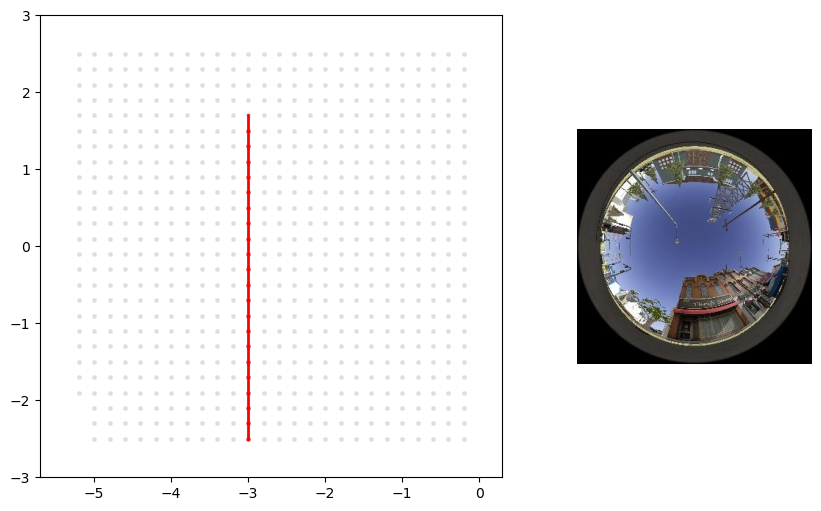

In [4]:
## Plots dataset
fig, (ax, ax_im) = plt.subplots(1, 2, figsize=(10,6), gridspec_kw={'width_ratios':[2,1]})
ax.set_aspect('equal')
ax.set_xlim(db_base['poses'][:,0].min()-0.5, db_base['poses'][:,0].max()+0.5)
ax.set_ylim(db_base['poses'][:,1].min()-0.5, db_base['poses'][:,1].max()+0.5)
ax.scatter(db_base['poses'][:,0], db_base['poses'][:,1], s=6, c="#cccccc", alpha=0.5, label="BDD poses")
ax.scatter(db_route['poses'][:,1], db_route['poses'][:,2], s=6, c="#ff0000", alpha=0.5, label="BDD poses")
ax.plot([db_route['poses'][:,1], db_route['poses'][:,1] + 0.2*np.cos(np.deg2rad(db_route['poses'][:,3]))], [db_route['poses'][:,2], db_route['poses'][:,2] + 0.2*np.sin(np.deg2rad(db_route['poses'][:,3]))],'r-', lw=2)
ax_im.axis("off")
ax_im.imshow(db_base['images'][0])  # NO cmap/vmin/vmax
plt.show()

## 3. Concevoir un **Mushroom Body** et visualiser une rIDF

Nous allons créer pas à pas une **classe MushroomBody** qui **encode**, **apprend** et **évalue la familiarité** d’une image par rapport à sa **mémoire**.

### A. Transformer une image en **Projection Neuronale (PN)** avec le **lobe optique**

Nous simulons la vision d’une fourmi avec le code des **optic lobes** déjà écrit. Ce module transforme une image classique en **projection neuronale (PN)**, comme dans les fonctions de prétraitement précédentes.
C’est un **objet** doté d’une **méthode unique** `create_pn(img)` qui renvoie :

* la **projection 2D** (image prétraitée) ;
* la **projection 1D** (le **vecteur PN**).

La création de l’objet **OL** prend :

* `target_px_scale` : **résolution** souhaitée en **degré/pixel** ;
* `sigma` : **quantité de flou** appliquée ;
* les **champs de vision** horizontal et vertical.
  Ici, le **FOV = 220°**, identique dans les deux directions (fisheye).

#### TODO

* [ ] Prendre une image de la **base route** (au choix) et la convertir en **PN** via la classe **OpticLobes**.
* [ ] **Visualiser** la **PN 2D**.
* [ ] **Afficher** le **nombre de PN** (dimension du vecteur 1D).


Optic Lobes initialized !
(1515,)


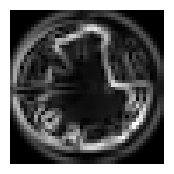

In [ ]:
from optic_lobes import OpticLobes

## Given variables
target_px_scale = 5
sigma = 3
H_FOV = 220
V_FOV = H_FOV

# Creation of the Optic Lobes
OL = OpticLobes(target_px_scale,sigma,H_FOV,V_FOV)

## TODO : Transform an image into a PN, and visualize the 2d version of it, print the size of the 1D PN



### B. Le **Mushroom Body**

> Ce Mushroom Body servira à **apprendre des vues** et à **estimer une familiarité** en fonction de sa **mémoire** (notre banque d’images). Dans les deux prochaines cellules :
>
> 1. **compléter** la classe *MushroomBody* ;
> 2. la **tester** sur une image pour **reproduire sa rIDF**.

#### TODO

* [ ] **Compléter** le code de la classe *MushroomBody* en suivant les instructions et les slides du cours.
* [ ] **Initialiser** un MB avec les **paramètres choisis** (donnés), **apprendre** une image (format **PN 1D** après passage dans l’OL) et **calculer** la familiarité (exemple fourni).
* [ ] **Compléter** la fonction `rotate_fisheye(img, angle)` qui **tourne** une image **circulaire fisheye** (différent d’une image équirectangulaire).
* [ ] **Compléter** la fonction de **calcul de la rIDF** avec un MB.
* [ ] **Apprendre** une image, **calculer** sa rIDF et **tracer** la courbe.
* [ ] **Comparer** le **temps de calcul** avec la méthode précédente, **comparer** les **résultats** et la **forme** de la rIDF.


In [ ]:
## Mushroom Body Class
class MushroomBody(object):
    def __init__(self,
                 PN_nb, # Number of PNs from the flatten, processed image (from optic lobes)
                 KC_nb, # Number of KCs | u in the lecture
                 KCtoPN_synapses, # Number of PNs connected to one EP (KCs) | s in the lecture
                 KC_norm_param):  # Proportion of KCs used to represent the encoded image | kappa in the lecture

        if KCtoPN_synapses > PN_nb:
            raise ValueError('KCtoPN_synapses must be <= PN_nb')

        start = time.time()
        # Cell numbers
        self._PN_nb = PN_nb
        self._KC_nb = KC_nb
        self._KCtoPN_synapses = KCtoPN_synapses
        self._normed_KC_nb = int(np.ceil(self._KC_nb * KC_norm_param))  # Number of KCs used to represent the encoded image | This is u bar

        self.__init_connection_weights()
        self.__init_cell_activities()

        end = time.time()
        print('\nMushroom Body initialized in {:.3f} secs.'.format(end-start))

    def __init_connection_weights(self):            #(Initilisation MB tuto 1.)
        ## Definition of the sparse, semi-random, and binary synpatic matrix W1 
        self.W1 = np.zeros((self._PN_nb, self._KC_nb), dtype='float32')
        self.W1[:self._KCtoPN_synapses, :] = 1.0
        for col in np.arange(self._KC_nb):
            np.random.shuffle(self.W1[:, col])

        ## Definition of the plastic synaptic vector W2 (which will be the memory) fully-connected.  
        self.W2 = np.ones(self._KC_nb, dtype='bool')

    def __init_cell_activities(self):
        self._pn_activity = np.zeros(self._PN_nb, dtype='float32')  # PN activity from the optic lobes
        self._kc_ePSP = np.zeros(self._KC_nb, dtype='float32')      # EP in the lecture
        self._kc_spikes = np.zeros(self._KC_nb, dtype='bool')       # AP in the lecture, after the k-WTA
        self._mbon_activity = 1                                    # Familiarity lambda in the lecture

    def _update_kc_ePSP(self):
        # TODO : Update here the vector EP (_kc_ePSP) from the PN activity and the W1 synaptic matrix (Expansion MB tuto 3.)

    def _update_kc_spikes(self):
        # TODO : Update the encoded image representation in AP (kc_spikes) with the k-WTA (Sparsification MB tuto 4.)

    def learn(self,view):
        # TODO : Create a learn function that will depress the synapse of W2 (False) when the kc_spikes or AP are activated (True) (Apprentissage MB tuto 5.a)

    def _update_mbon_activity(self):
        # TODO : Update the _mbon_activity, lambda in the lecture. herre instead of the sum and multiplication
        # use np.count_nonzero(...) cause they're bool (Exploitation MB tuto 5.b)

    ## Given function that will be called to update all layers from the current PN to the familiarity, from the EP and AP (encoded image)
    ## To be called during learn of get_unfamiliarity
    def refresh(self, view=None):
        self._pn_activity[:] = np.asarray(view, dtype='float32')
        self._update_kc_ePSP()
        self._update_kc_spikes()
        self._update_mbon_activity()

    def get_unfamiliarity(self,view):
        # TODO Call refresh here and return the mbon activity (familiarity)



(1515,)

Mushroom Body initialized in 0.235 secs.
Temps de calcul = 0.4s


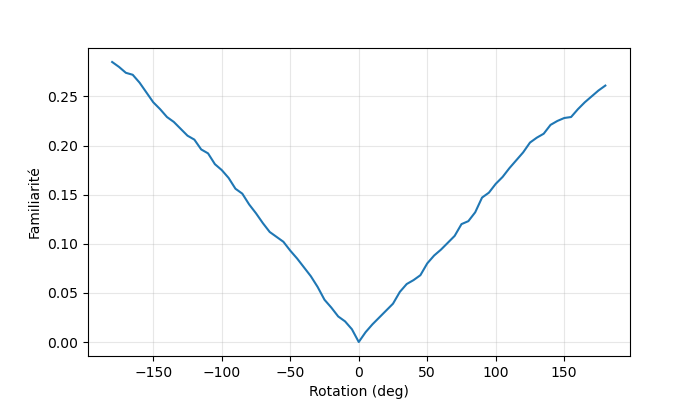

In [ ]:

## Example of a test of the MB Class
## Given variables
KC_nb = 10000            
KCtoPN_synapses = 4     
KC_norm_param = 0.1   
THETAS = np.arange(-180, 181, 5)  # <- à ajuster selon votre dataset (pas en degrés)

## Create the Optic Lobes and initial PN
img_init = db_route["images"][0]
pn_init_2d,pn = OL.create_pn(img_init)
print(pn.shape)

## Create the Mushroom Body and learn one image and compute the familiarity
MB = MushroomBody(PN_nb=len(pn),KC_nb=KC_nb,KCtoPN_synapses=KCtoPN_synapses,KC_norm_param=KC_norm_param)
MB.learn(pn)
MB.get_unfamiliarity(pn)

## --- Your turn --- 
def rotate_fisheye(img,angle):
    # TODO : Create a function that will rotate the fisheye image from its center to a determined angle (use opencv)

def ridf_mb(MB, image, thetas_deg=np.arange(-180, 181, 1)):
    # TODO : Create the rIDF function between the MB and a current tested image

# TODO : Call the function and compare the time between the precedent TP, explain why

# TODO : Plot the rIDF


## 4. Apprendre une route avec un **Mushroom Body**

Nous allons traiter et **apprendre** toutes les images de la **base route** dans un MB.

### TODO

* [ ] **Compléter** la fonction `learn_route(db_route, OL, MB, save=False)` qui prend la base d’images, l’objet **OL**, le **MB** et un paramètre `save` pour **enregistrer les vecteurs intéressants**.
* [ ] **Compléter** la fonction `show_kc_maps(history, KC_nb, shape=None)` qui utilise l’historique d’apprentissage pour **afficher les remaps des vecteurs intéressants** (comme vu en cours).
* [ ] **Initialiser** un nouveau MB, **apprendre** la route et **appeler** le plotter.
* [ ] **Compléter** la fonction `ridf_fam_path(MB, img_tests, thetas_deg=np.arange(-180, 181, 1))`, qui s’appuie sur `ridf_mb(MB, image, thetas_deg)` pour **calculer la rIDF 3D** de chaque image de la base route par rapport à la **mémoire** du MB.
* [ ] **Appeler** cette fonction et **tracer** la **surface 3D** (x = index d’image, y = θ, z = familiarité du MB) ainsi que la **heatmap** (vue du dessus).



Mushroom Body initialized in 0.233 secs.
Time : 0.3s


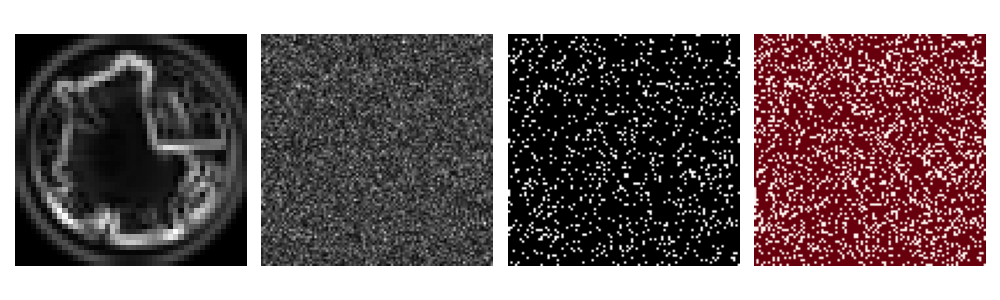

In [ ]:
# Function given, it compute the best visualisation shape to visualise a 1D vector into a remapped 2D image
def best_2d_shape(n: int):
    """
    Return (H, W) such that H*W=n and |H-W| is small (closest to square).
    If n is prime, this will fall back to (1, n).
    """
    s = int(np.floor(np.sqrt(n)))
    for h in range(s, 0, -1):
        if n % h == 0:
            return (h, n // h)
    return (1, n)

def learn_route(db_route, OL, MB, save=False):
    # TODO : Create a function that will learn all the images from the route database in a MB, 
    # save the final 2d pn, W2 vector, ePSP, and spikes.


def show_kc_maps(history, KC_nb, shape=None):
    # TODO : Display the final 2d pn, W2 vector, ePSP, and spikes in the best shape (image is already in 2d).


# TODO : Create a New MB, learn the route database, show the time needed, and call the plotter


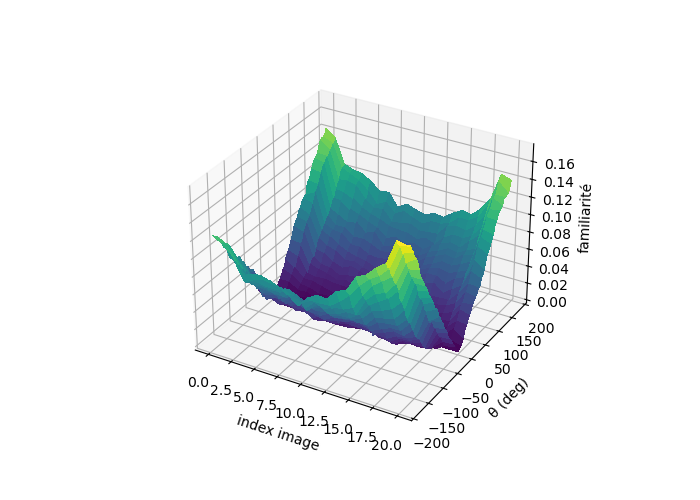

In [ ]:
def ridf_fam_path(MB, img_tests, thetas_deg=np.arange(-180, 181, 1)):
    # TODO : Compute the rIDF 3D for each image in the route database, (as in the previous TP but here with the MB as the reference)
    # the image in the route database will be the image test. Use the previous ridf_mb(MB,im,thetas_deg) function


# TODO : Compute the rIDF 3D for each image in the route database,


# TODO : Surface 3D: x = index image, y = theta, z = familiarité

# TODO : Heatmap 2D de la RIDF : x = index image, y = θ, couleur = familiarité



## 5. Estimation de l’erreur de cap avec un MB

Les avantages d’un **Mushroom Body (MB)** par rapport à une base de données classique :

* Il ne teste pas **toutes** les images de la base (il interroge uniquement sa **mémoire W2**).
* **Aucune image** n’est sauvegardée.
* C’est généralement **plus rapide**.

En contrepartie, on **perd l’information de position** sur la route.

### TODO

* [ ] **Compléter** la fonction `argmin_ridf_mb(img_test, MB, THETAS)` qui prend une **image test**, le **MB** et les **paramètres de scan**, et qui retourne le **profil de familiarité** (angle ↦ familiarité) ainsi que **l’angle minimisant** la familiarité (cap estimé).
* [ ] **Choisir** une image **aléatoire** et l’**orienter aléatoirement** pour le test.
* [ ] **Appeler** la fonction de recherche du minimum et **comparer** l’**angle vrai** (celui tiré aléatoirement) au **cap estimé** ; **rapporter** l’**erreur** et le **temps de calcul**.
* [ ] **Tracer** la **rIDF**.


idx=9, angle_deg=-17.4
Cap estimé : -10.0° | Erreur d'estimation : 7.4°
Temps de calcul = 0.4s


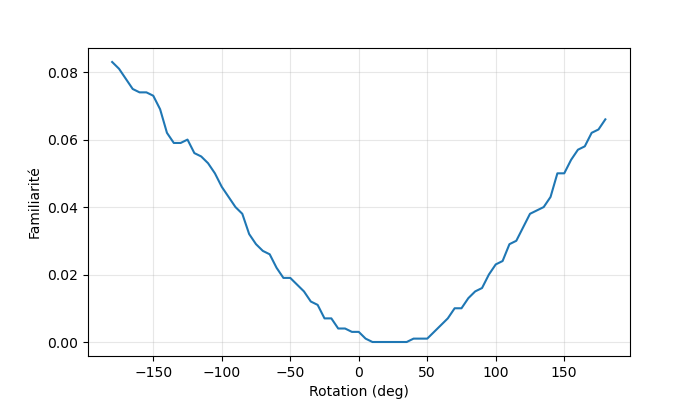

In [ ]:

def argmin_ridf_mb(img_test,MB,THETAS):
    # TODO : Compute the argmin of the rIDF


# TODO : choose a random image at a random orientation for further test from the route database

# TODO : Test the argmin_ridf_mb(img_test,MB,THETAS) functio, display the estimated heading, 
# and the estimation error between the truth and the estimation

## TODO : Plot the ridf


## Aller plus loin

Analysez les résultats et **comparez** avec le TP précédent.
Si vous le souhaitez, vous pouvez **tester** avec la base de données de la **route** et les images **équirectangulaires** pour montrer que la **forme de la rIDF dépend** de l’environnement et de la **caméra**.

Vous pouvez aussi **étudier** comment évolue la **familiarité** en fonction de la **distance à la route**.
Au passage, connaissez-vous le **repère de Frenet** ? 😉
